In [1]:
import csv
import glob
import os
from typing import List

class Group:
    def __init__(self, total_time: float = None, members: List[str] = None):
        self.total_time = total_time
        self.members = members if members is not None else []
    
    def __str__(self):
        members_str = ", ".join(self.members)
        return f"Total time: {self.total_time}\nMembers: {members_str}\n"

class Time:
    def __init__(self, total_time: float = None, groups: List[Group] = None):
        self.total_time = total_time
        self.groups = groups if groups is not None else []
    
    def __str__(self):
        return f"Total time: {self.total_time}\nGroups: {'/n'.join([str(group) for group in self.groups])}"

class Reply:
    def __init__(self, row, labels):
        index = 0
        iterator = iter(row)
        self.response_id = next(iterator)
        self.date_submitted = next(iterator)
        self.last_page = next(iterator)
        self.start_language = next(iterator)
        self.seed = next(iterator)
        self.date_started = next(iterator)
        self.date_last_action = next(iterator)
        self.referrer_url = next(iterator)
        index += 8

        # entry 8 to 74 are the requirements
        # entry 43 and 48 need to be skipped, they are outdated
        self.scores = []
        self.questions = []
        while index < 75:
            score = next(iterator)
            if index not in [43, 48]:
                self.questions.append(labels[index])
                self.scores.append(score)
            index += 1

        self.age = next(iterator)
        self.education = next(iterator)
        self.education_other = next(iterator)
        self.survey_count = next(iterator)
        self.experience = next(iterator)
        self.comments = next(iterator)
        index += 6

        # the time is an object and holds nested values for the 10 groups
        self.time = Time()
        self.time.total_time = next(iterator)
        index += 1

        # iterate over groups
        while index < len(labels)-1:
            if labels[index].startswith("Group time:"):
                self.time.groups.append(Group())
                self.time.groups[-1].total_time = next(iterator)
            else:
                self.time.groups[-1].members.append(next(iterator))
            index += 1
    
    def __str__(self):
        return f"Reply: {self.response_id}\nDate submitted: {self.date_submitted}\nLast page: {self.last_page}\nStart language: {self.start_language}\nSeed: {self.seed}\nDate started: {self.date_started}\nDate last action: {self.date_last_action}\nReferrer URL: {self.referrer_url}\nScores: {self.scores}\nAge: {self.age}\nEducation: {self.education}\nEducation other: {self.education_other}\nSurvey count: {self.survey_count}\nExperience: {self.experience}\nComments: {self.comments}\n{self.time}\n"

# Specify the folder where your CSV files are located
bnw_data_path = os.path.join("c:\\", "workspace", "borgnetzwerk", "tools", "scripts", "SWARM-SLR", "data")
folder_path = os.path.join("c:\\", "workspace", "surveys")

# Create a pattern to match files starting with "results-survey" and ending with ".csv"
file_pattern = os.path.join(folder_path, 'results-survey*.csv')

# Get a list of file paths matching the pattern
csv_files = glob.glob(file_pattern)

replies: List[Reply] = []

# Iterate through each CSV file
for csv_file in csv_files:
    print(f"Reading data from file: {csv_file}")

    # Open the CSV file
    with open(csv_file, 'r') as file:
        # Create a CSV reader
        csv_reader = csv.reader(file)

        # Read the header (labels) and store them in a separate list
        labels = next(csv_reader)

        # Initialize an empty list to store rows
        rows = []

        # Iterate through each row and append it to the rows list
        for row in csv_reader:
            rows.append(row)

        # setting up row handling            
        last_page_index = labels.index("Last page")
        expected_last_page = "10"

        # Iterate over all rows with an index (i) and the row (row)
        for i, row in enumerate(rows):
            # Skip rows that did not complete the survey
            if not row or row[last_page_index] != expected_last_page:
                continue
            # Create a reply object
            reply = Reply(row, labels)

            # Append the reply to the list of replies
            replies.append(reply)

            # Print the reply
            # print(reply)

Reading data from file: c:\workspace\surveys\results-survey555283.csv


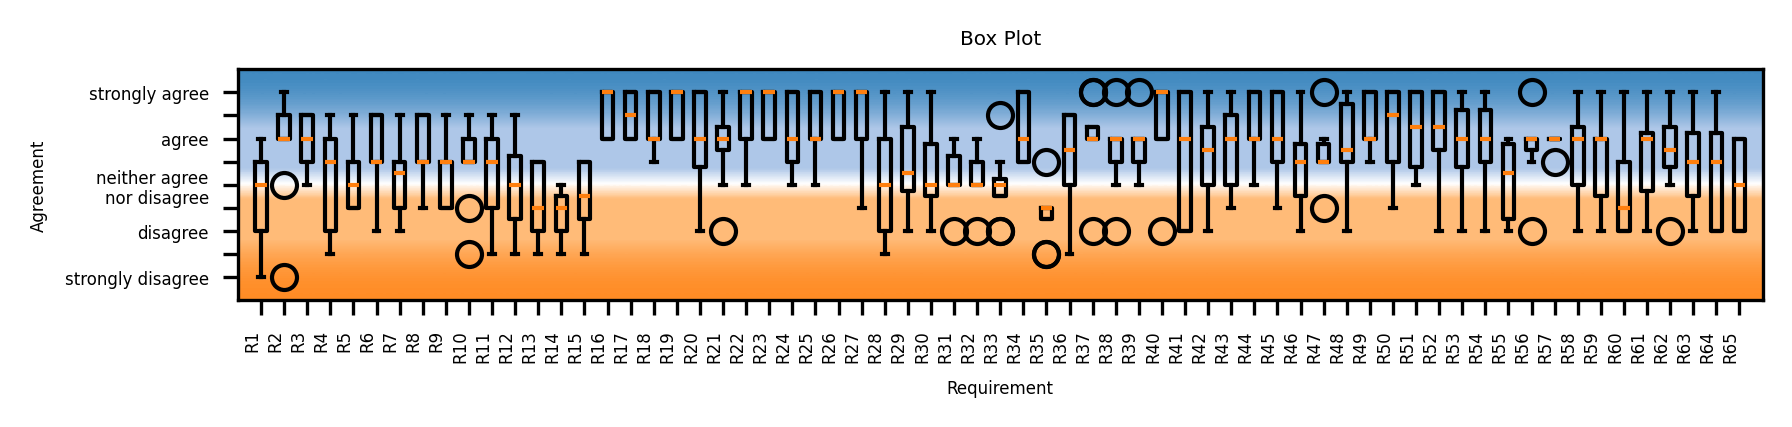

In [2]:
import matplotlib.pyplot as plt
from  matplotlib.colors import LinearSegmentedColormap

def create_box_plot(data, labels=None, vert=True):
    """
    Create a horizontal box plot from a List of Lists.

    Parameters:
    - data: List of Lists containing the data for each box.
    - labels: Labels for each box plot (categories).

    Returns:
    - None (displays the plot).
    """
    font = {'size'   : 4}

    plt.rc('font', **font)
    c = ["#FF7F0E","#FFBB78","#FFBB78","white", "#AEC7E8","#AEC7E8","#1F77B4"]
    v = [0,.175,.4,.5,0.6,.825,1.]
    l = list(zip(v,c))

    cmap=LinearSegmentedColormap.from_list('rg',l, N=256)

    agreement = ["strongly agree", "", "agree", "", "neither agree\nnor disagree", "", "disagree", "", "strongly disagree"]

    if vert:
        fig, ax = plt.subplots(dpi=300, figsize=(30, 1))
        plotlim = plt.xlim(0,len(data)+1) + plt.ylim(10,0)  

        ax.imshow([[0.5,0.5],[0,0]], cmap=cmap, interpolation='bicubic', extent=plotlim)  
        
        ax.set_ylabel('Agreement')
        # set the x ticks from 1 to 9
        ax.set_yticks(range(1,10))
        ax.set_yticklabels(agreement)

        ax.set_xlabel('Requirement')
        plt.setp(ax.get_xticklabels(), rotation=90, horizontalalignment='right')

    else:
        fig, ax = plt.subplots(dpi=300, figsize=(1, 30))
        plotlim = plt.xlim(1,9) + plt.ylim(len(data),0)  

        ax.imshow([[1,0],[1,0]], cmap=cmap, interpolation='bicubic', extent=plotlim)  
      
        ax.set_xlabel('Values')

        ax.set_ylabel('Requirement')

    ax.set_title('Box Plot')
    ax.boxplot(data, vert=vert, labels=labels)


    
    # ax.legend(labels, title='Categories', loc='upper left', bbox_to_anchor=(1, 1))

    plt.show()
    path = os.path.join(bnw_data_path, 'boxplot.png')
    fig.savefig(path, bbox_inches='tight')

# Example usage:
csv_file_path = 'your_data.csv'

data = []
labels = []

for reply in replies:
    for i, score in enumerate(reply.scores):
        res = None
        if score:
            res = int(score[1:])
        if i >= len(data):
            data.append([])
        if res:
            data[i].append(res)
    if not labels:
        # this is horribly large
        labels = reply.questions
        for i, label in enumerate(labels):
            labels[i] = f"R{i+1}"

if not data:
    print(f"File '{csv_file_path}' not found.")
    data = [
        [1, 2, 3, 4, 5],
        [2, 3, 4, 5, 6],
        [3, 4, 5, 6, 7]
    ]
    labels = ['Category 1', 'Category 2', 'Category 3']


if data:
    create_box_plot(data, labels)